In [1]:
from openvino.runtime import Core
import matplotlib
import PIL
from PIL import ImageDraw
import numpy as np
import json

In [2]:
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

**Select a test image**

In [3]:
test_file = 'demo.jpg'

(1535, 864)


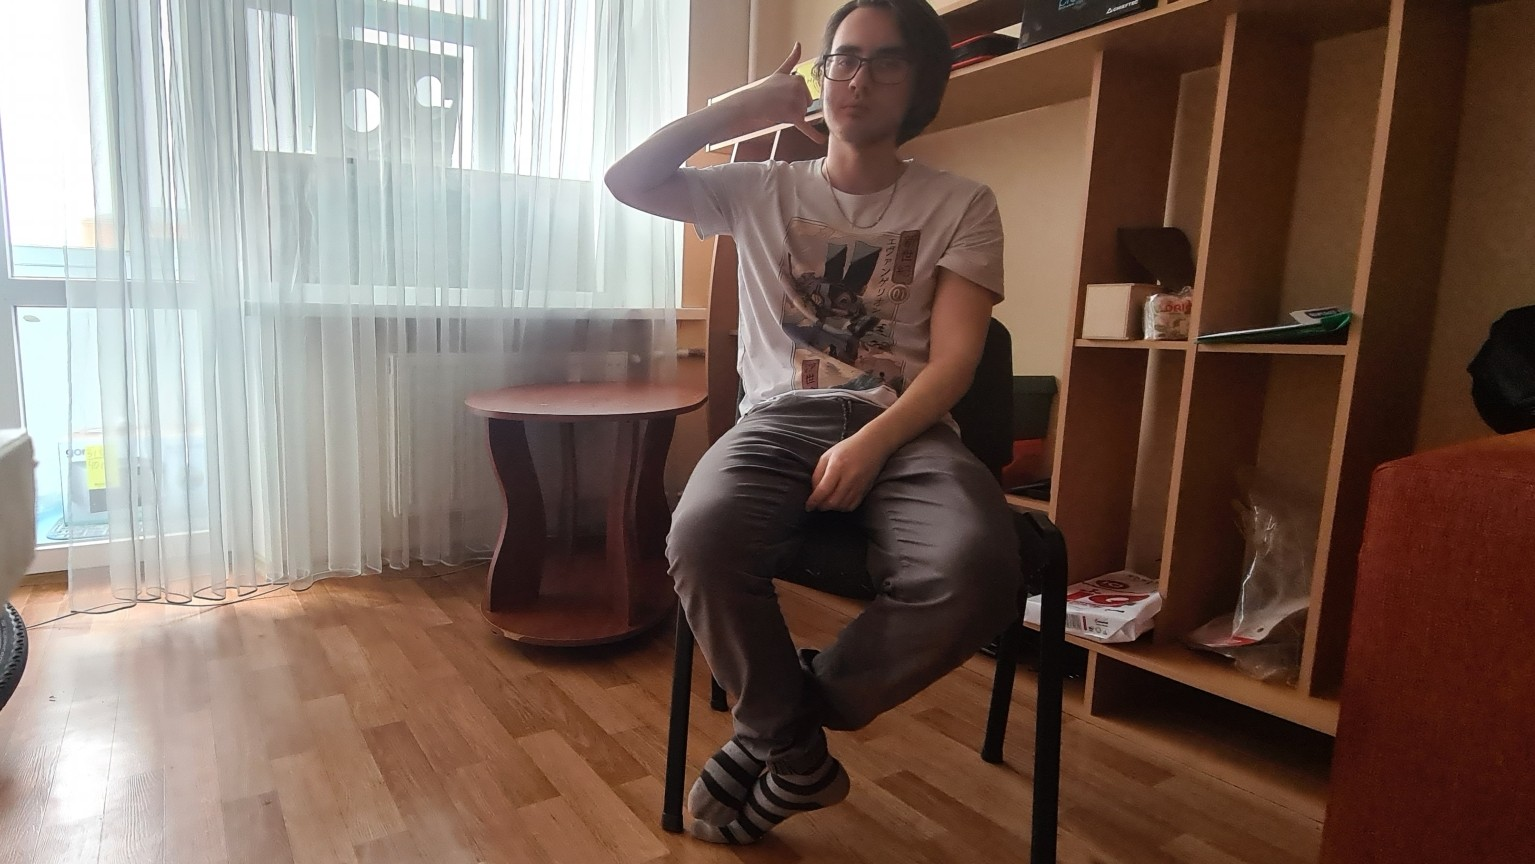

In [4]:
test_img = PIL.Image.open(test_file).convert('RGB')
print(test_img.size)
test_img

**Define stride values**

In [5]:
strides = [8, 16, 32]
max_stride = max(strides)

**Calculate valid input dimensions**

In [6]:
input_w = test_img.width - (test_img.width % max_stride)
input_h = test_img.height - (test_img.height % max_stride)
input_w, input_h

(1504, 864)

**Calculate corner locations for cropped image**

In [7]:
left = (test_img.width - input_w)/2
upper = (test_img.height - input_h)/2
right = test_img.width - left
lower = test_img.height - upper
left, upper, right, lower

(15.5, 0.0, 1519.5, 864.0)

**Crop image to supported resolution**

(1504, 864)


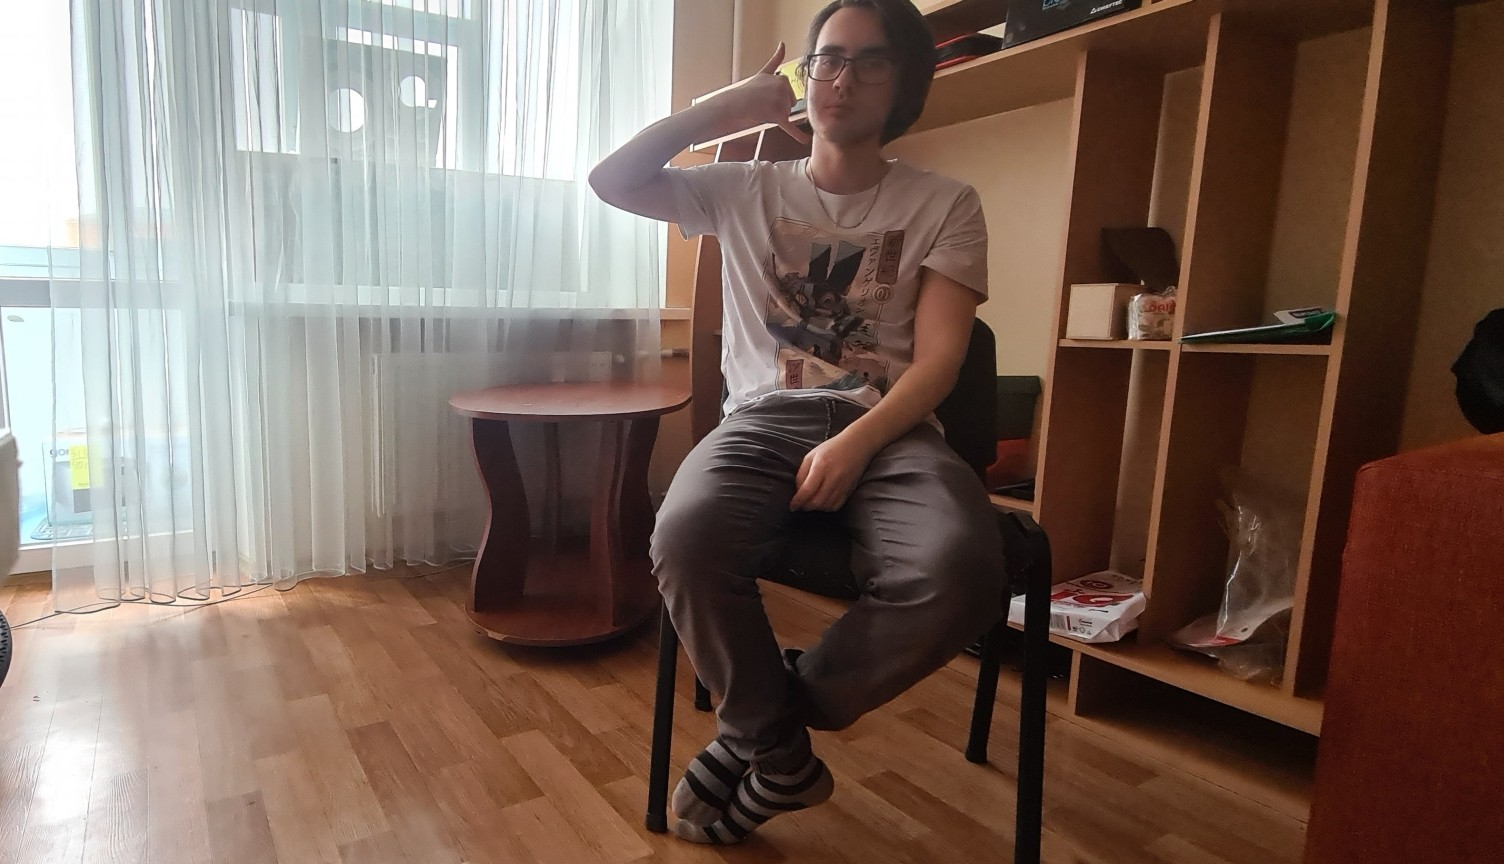

In [8]:
test_img = test_img.crop((left, upper, right, lower))
print(test_img.size)
test_img

**Define model name**

In [9]:
model_name = 'hagrid-sample-30k-384p'

**Define path to OpenVINO IR model**

In [10]:
ir_path = f"{model_name}-YOLOX.xml"
ir_path

'hagrid-sample-30k-384p-YOLOX.xml'

**Convert image to numpy array and scale pixel values**

In [11]:
# Convert image to tensor
img_tensor = np.array(test_img).transpose((2, 0, 1))
# Scale pixels values from [0,255] to [0,1]
scaled_tensor = img_tensor / 255

**Batch input tensor**

In [12]:
input_image = np.expand_dims(scaled_tensor, axis=0)
input_image.shape

(1, 3, 864, 1504)

**Get available OpenVINO compute devices**

In [13]:
ie = Core()
devices = ie.available_devices
for device in devices:
    device_name = ie.get_property(device_name=device, name="FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: 11th Gen Intel(R) Core(TM) i7-11700K @ 3.60GHz


**Perform inference using OpenVINO IR model**

In [14]:
# Load the network in Inference Engine
ie = Core()
model_ir = ie.read_model(model=ir_path)
model_ir.reshape(input_image.shape)
compiled_model_ir = ie.compile_model(model=model_ir, device_name="CPU")

# Get input and output layers
input_layer_ir = next(iter(compiled_model_ir.inputs))
output_layer_ir = next(iter(compiled_model_ir.outputs))

# Run inference on the input image
res_ir = compiled_model_ir([input_image])[output_layer_ir]

**Define method to generate stride values to navigate the raw model output**

In [15]:
def generate_grid_strides(height, width, strides=[8, 16, 32]):
    
    grid_strides = []

    # Iterate through each stride value
    for stride in strides:
        # Calculate the grid dimensions
        grid_height = height // stride
        grid_width = width // stride

        # Store each combination of grid coordinates
        for g1 in range(grid_height):
            
            for g0 in range(grid_width):
                grid_strides.append({'grid0':g0, 'grid1':g1, 'stride':stride })
    
    return grid_strides

**Generate stride values to navigate model output**

In [16]:
grid_strides = generate_grid_strides(test_img.height, test_img.width, strides)

**Define method to generate object detection proposals from the raw model output**

In [17]:
def generate_yolox_proposals(feat_ptr, proposal_length, grid_strides, bbox_conf_thresh=0.3):
    
    proposals = []
    
    # Obtain the number of classes the model was trained to detect
    num_classes = proposal_length - 5

    for anchor_idx in range(len(grid_strides)):
        
        # Get the current grid and stride values
        grid0 = grid_strides[anchor_idx]['grid0']
        grid1 = grid_strides[anchor_idx]['grid1']
        stride = grid_strides[anchor_idx]['stride']

        # Get the starting index for the current proposal
        start_idx = anchor_idx * proposal_length

        # Get the coordinates for the center of the predicted bounding box
        x_center = (feat_ptr[start_idx + 0] + grid0) * stride
        y_center = (feat_ptr[start_idx + 1] + grid1) * stride

        # Get the dimensions for the predicted bounding box
        w = np.exp(feat_ptr[start_idx + 2]) * stride
        h = np.exp(feat_ptr[start_idx + 3]) * stride

        # Calculate the coordinates for the upper left corner of the bounding box
        x0 = x_center - w * 0.5
        y0 = y_center - h * 0.5

        # Get the confidence score that an object is present
        box_objectness = feat_ptr[start_idx + 4]

        # Initialize object struct with bounding box information
        obj = { 'x0':x0, 'y0':y0, 'width':w, 'height':h, 'label':0, 'prob':0 }

        # Find the object class with the highest confidence score
        for class_idx in range(num_classes):
            
            # Get the confidence score for the current object class
            box_cls_score = feat_ptr[start_idx + 5 + class_idx]
            # Calculate the final confidence score for the object proposal
            box_prob = box_objectness * box_cls_score
            
            # Check for the highest confidence score
            if (box_prob > obj['prob']):
                obj['label'] = class_idx
                obj['prob'] = box_prob

        # Only add object proposals with high enough confidence scores
        if obj['prob'] > bbox_conf_thresh: proposals.append(obj)
    
    proposals.sort(key=lambda x:x['prob'], reverse=True)
    return proposals

**Define minimum confidence score for keeping bounding box proposals**

In [18]:
bbox_conf_thresh = 0.65

**Define path to the color map for the selected model**

In [19]:
color_map_file_path = f'{model_name}-colormap.json'

**Load the color map for the selected model**

In [20]:
with open(color_map_file_path, "r") as read_file:
    raw_json = read_file.read()
    color_map = json.loads(raw_json)
pd.DataFrame(color_map['items'])

label                        color
0              call              [0.0, 1.0, 0.0]
1        no_gesture              [1.0, 0.0, 1.0]
2           dislike              [0.0, 0.5, 1.0]
3              fist              [1.0, 0.5, 0.0]
4              four             [0.5, 0.75, 0.5]
5              like  [0.30555, 0.01317, 0.67298]
6              mute  [0.87746, 0.03327, 0.29524]
7                ok  [0.05583, 0.48618, 0.15823]
8               one  [0.95094, 0.48649, 0.83322]
9              palm   [0.0884, 0.99616, 0.95391]
10            peace              [1.0, 1.0, 0.0]
11   peace_inverted   [0.52176, 0.27352, 0.0506]
12             rock  [0.55398, 0.36059, 0.57915]
13             stop   [0.08094, 0.99247, 0.4813]
14    stop_inverted   [0.49779, 0.8861, 0.03131]
15            three   [0.49106, 0.6118, 0.97323]
16           three2  [0.98122, 0.81784, 0.51752]
17           two_up  [0.02143, 0.61905, 0.59307]
18  two_up_inverted              [0.0, 0.0, 1.0]

**Extract labels from colormap**

In [21]:
labels = [item['label'] for item in color_map['items']]

**Process raw model output**

In [22]:
proposals = generate_yolox_proposals(res_ir.flatten(), res_ir.shape[2], grid_strides, bbox_conf_thresh)
proposals_df = pd.DataFrame(proposals)
proposals_df['label'] = proposals_df['label'].apply(lambda x: labels[x])
proposals_df

x0          y0       width      height       label      prob
0   787.666898  430.553030   90.888527   83.934563  no_gesture  0.855598
1   788.077043  431.791987   90.908043   83.428963  no_gesture  0.855518
2   789.381336  430.830310   90.320984   83.513657  no_gesture  0.852360
3   790.567509  432.624325   88.972961   82.140160  no_gesture  0.851652
4   708.052367   38.292552  105.863632  108.728935        call  0.826763
5   790.456493  431.599762   86.779755   83.422554  no_gesture  0.820307
6   788.573249  430.776163   91.075043   85.203651  no_gesture  0.816736
7   789.721667  430.999898   86.991943   83.146851  no_gesture  0.811889
8   708.650934   39.812711  104.424950  108.178505        call  0.800333
9   710.785334   40.079414  101.459572  110.256599        call  0.792352
10  710.735335   38.389003  102.802559  110.465248        call  0.780800
11  708.336198   40.141655  102.167885  108.911598        call  0.732676
12  698.459045   40.091926  113.808609  109.926987        call  0.697700
13  711.792835   39.124123   97.822212  113.312210        call  0.676024

**Define function to calculate the union area of two bounding boxes**

In [23]:
def calc_union_area(a, b):
    x = min(a['x0'], b['x0'])
    y = min(a['y0'], b['y0'])
    w = max(a['x0']+a['width'], b['x0']+b['width']) - x
    h = max(a['y0']+a['height'], b['y0']+b['height']) - y
    return w*h

**Define function to calculate the intersection area of two bounding boxes**

In [24]:
def calc_inter_area(a, b):
    x = max(a['x0'], b['x0'])
    y = max(a['y0'], b['y0'])
    w = min(a['x0']+a['width'], b['x0']+b['width']) - x
    h = min(a['y0']+a['height'], b['y0']+b['height']) - y
    return w*h

**Define function to sort bounding box proposals using Non-Maximum Suppression**

In [25]:
def nms_sorted_boxes(nms_thresh=0.45):
    
    proposal_indices = []
    
    # Iterate through the object proposals
    for i in range(len(proposals)):
        
        a = proposals[i]
        keep = True

        # Check if the current object proposal overlaps any selected objects too much
        for j in proposal_indices:
            
            b = proposals[j]

            # Calculate the area where the two object bounding boxes overlap
            inter_area = calc_inter_area(a, b)

            # Calculate the union area of both bounding boxes
            union_area = calc_union_area(a, b)
            
            # Ignore object proposals that overlap selected objects too much
            if inter_area / union_area > nms_thresh: keep = False

        # Keep object proposals that do not overlap selected objects too much
        if keep: proposal_indices.append(i)
    
    return proposal_indices

**Define threshold for sorting bounding box proposals**

In [26]:
nms_thresh = 0.45

**Sort bouning box proposals using NMS**

In [27]:
proposal_indices = nms_sorted_boxes(nms_thresh)
proposals_df.iloc[proposal_indices]

x0          y0       width      height       label      prob
0  787.666898  430.553030   90.888527   83.934563  no_gesture  0.855598
4  708.052367   38.292552  105.863632  108.728935        call  0.826763

**Extract colors from colormap and scale color values to `[0,255]`**

In [28]:
colors = [item['color'] for item in color_map['items']]

**Annotate image using bounding box proposals**

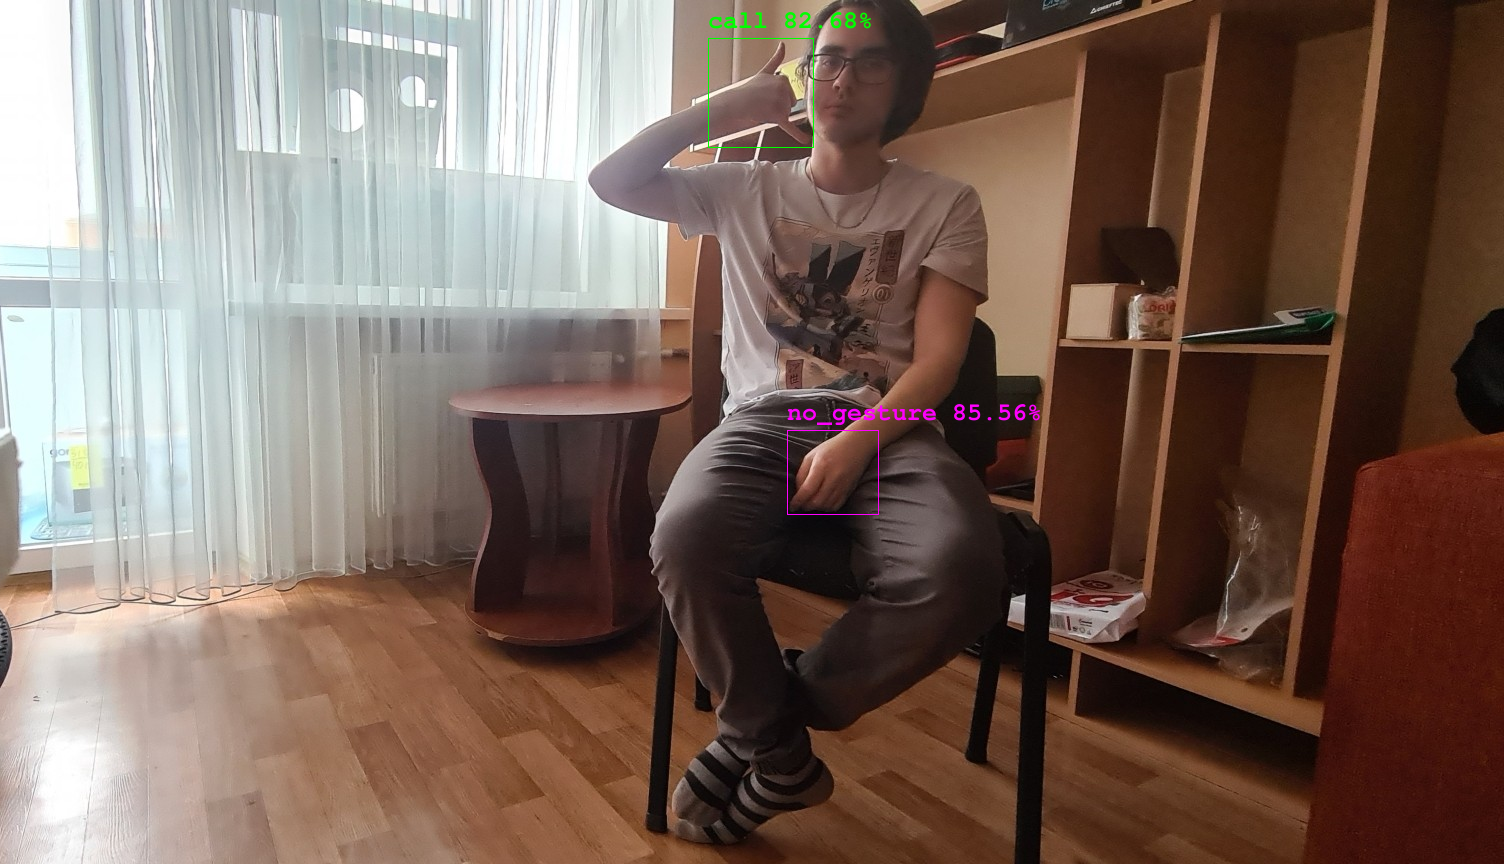

In [29]:
annotated_img = test_img.copy()
draw = ImageDraw.Draw(annotated_img)
fnt_size = 25
for i in proposal_indices:
    x, y, w, h, l, p = proposals[i].values()
    shape = (x, y, x+w, y+h)
    color = tuple([int(ch*255) for ch in colors[proposals[i]['label']]])
    draw.rectangle(shape, outline=color)
    fnt = PIL.ImageFont.truetype("Pillow/Tests/fonts/FreeMonoBold.ttf", fnt_size)
    draw.multiline_text((x, y-fnt_size-5), f"{labels[l]} {p*100:.2f}%", font=fnt, fill=color)
annotated_img

**Save annotated image**

In [30]:
annotated_img.save('output.png')

**Benchmark OpenVINO IR CPU inference speed**

In [31]:
%%timeit
compiled_model_ir([input_image])

133 ms ± 4.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
